### 1、数据处理

#### 1.1 定义数据

In [15]:
# 输入
dataset_x='<BEGIN>,<END>,<PAD>,a,b,c,d,e,f,g,1,2,3,4,5,6,7,8,9'
# 输入表示为字典形式
dataset_x={word:i for i,word in enumerate(dataset_x.split(","))}
dataset_xr=[k for k,v in dataset_x.items()]

In [16]:
dataset_y={k.upper():v for k,v in dataset_x.items()}
dataset_yr=[k for k,v in dataset_y.items()]

#### 1.2 构建数据集

简单做个翻译的小模型，目标是，输入小写字母，输出对应大写字母，输入10以内的数字，输出10-输入的数字

In [3]:
import random

import numpy as np
import torch

In [19]:
def get_data():
    # 定义词的集合，总共像上面的x
    words=[
        'a','b','c','d','e','f','g','1','2','3','4','5','6','7','8','9'
    ]
    
    # 定义被选中的概率
    all_words_len=len(words)
    p=np.arange(1,all_words_len+1)
    
    p=p/p.sum()
    
    # 随机选n个词
    n=random.randint(20,30)
    x=np.random.choice(words,size=n,replace=True,p=p)
    
    # 采样的结果就是x，变成List
    x = x.tolist()
    
    # 怎么变换
    def convert(i):
        i=i.upper()
        if not i.isdigit():
            return i
        i=10-int(i)
        return str(i)
    
    y=[convert(i) for i in x]
    # 因为输出和输入不一定是一样的大小，所以假设y多了1位
    # 这1位是最后一个词放前面
    y=[y[-1]]+y
    
    # 加上首尾符号
    x=['<BEGIN>']+x+['<END>']
    y=['<BEGIN>']+y+['<END>']
    
    # 补PAD，既然上面的是随机20到30，这里补长度到40
    x=x+['<PAD>']*40
    y=y+['<PAD>']*41
    
    x=x[:40]
    y=y[:41]
    
    # 编码成数据
    # 编码成数据
    x = [dataset_x[i] for i in x]
    y = [dataset_y[i] for i in y]
    
    # 转tensor
    x = torch.LongTensor(x)
    y = torch.LongTensor(y)
    
    return x,y

In [5]:
# 定义数据集
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        super(Dataset, self).__init__()

    def __len__(self):
        return 100000

    def __getitem__(self, i):
        return get_data()


# 数据加载器
loader = torch.utils.data.DataLoader(dataset=Dataset(),
                                     batch_size=8,
                                     drop_last=True,
                                     shuffle=True,
                                     collate_fn=None)

### 2、工具函数

#### 2.1 注意力函数


这里表示的是attention是怎么计算的

$$AttentionScore=softmax(\frac{QK^T}{\sqrt{d_k}})*V$$

d_k表示的是多头对应的8维向量，这样计算是为了把结果约束到0-1之间，不然随着训练增加，数字会很大

In [154]:
def attention(Q,K,V,mask):
    # b句话,每句话40个词,每个词编码成32维向量,4个头,每个头分到8维向量
    # Q,K,V = [b, 4, 40, 8]
    # Q,K,V = [b, head_num, 40_words, 8]
    
    # [b, 4, 40, 8] * [b, 4, 8, 40] -> [b, 4, 40, 40]
    # Q,K矩阵相乘,求每个词相对其他所有词的注意力
    # QK.T
    score = torch.matmul(Q, K.permute(0, 1, 3, 2))
    
    
    # 除以每个头维数的平方根,做数值缩放
    # [b, 4, 40, 40]
    # QK.T/根号dk
    score /= (8 ** 0.5)
    
    # mask遮盖,mask是true的地方都被替换成-inf,这样在计算softmax的时候,-inf会被压缩到0
    # mask = [b, 1, 40, 40]
    score = score.masked_fill_(mask, -float('inf'))
    # softmax过程
    score = torch.softmax(score, dim=-1)
    
    # 以注意力分数乘以V,得到最终的注意力结果
    # softmax((QK.T)/根号dk)*V
    # [b, 4, 40, 40] * [b, 4, 40, 8] -> [b, 4, 40, 8]
    score = torch.matmul(score, V)
    
    # 每个头计算的结果合一
    # [b, 4, 40, 8] -> [b, 40, 32]
    score = score.permute(0, 2, 1, 3).reshape(-1, 40, 32)
    
    return score

#### 2.2 多头注意力层

In [155]:
class MultiHead(torch.nn.Module):
    
        def __init__(self):
            # 这些是Q,K,V对应的线性矩阵，把输入x通过线性矩阵变成对应的Q,K,V
            super().__init__()
            self.fc_Q = torch.nn.Linear(32, 32)
            self.fc_K = torch.nn.Linear(32, 32)
            self.fc_V = torch.nn.Linear(32, 32)
            
            # 输出的全连接层
            self.out_fc = torch.nn.Linear(32, 32)
            
            # 规范化LN
            self.norm = torch.nn.LayerNorm(normalized_shape=32, elementwise_affine=True)
            
            # 防止过拟合
            self.dropout = torch.nn.Dropout(p=0.1)
            
        def forward(self,Q,K,V,mask):
            # 多头注意力层
            
            # b句话,每句话40个词,每个词编码成32维向量
            # Q,K,V = [b, 40, 32]
            b = Q.shape[0]
            
            # 保留下原始的Q,后面要做短接用
            clone_Q = Q.clone()
            
            # 规范化，放在所有过程之前是因为经过验证，放在之前可以让模型收敛的更快
            Q = self.norm(Q)
            K = self.norm(K)
            V = self.norm(V)
            
            # 线性运算,维度不变
            # [b, 40, 32] * [b, 32, 32]-> [b, 40, 32]
            Q = self.fc_Q(Q)
            K = self.fc_K(K)
            V = self.fc_V(V)
            
            # 拆分成多个头
            # b句话,每句话4=个词,每个词编码成32维向量,4个头,每个头分到8维向量
            
            # [b, 40, 32] -> [b, 4, 40, 8]
            Q = Q.reshape(b, 40, 4, 8).permute(0, 2, 1, 3)
            K = K.reshape(b, 40, 4, 8).permute(0, 2, 1, 3)
            V = V.reshape(b, 40, 4, 8).permute(0, 2, 1, 3)
            
            # 这下这些Q,K,V的形状和attention要求的输入形状一样了
            # 计算注意力
            # [b, 4, 40, 8] -> [b, 40, 32]
            score = attention(Q, K, V, mask)
            
            # 计算输出,维度不变
            # [b, 40, 32] -> [b, 40, 32]
            score = self.dropout(self.out_fc(score))
            
            # 短接，transformer里的残差链接吧
            score = clone_Q + score
            return score

#### 2.3 位置编码层

这里表示模型在考虑输入的时候需要考虑每一个字的位置，why?理由如下：

“我欠你1000元”

“你欠我1000元”

这两句话长度一样，文字也一样，但是由于“我”和“你”位置不一样，意思完全不一样，如果用RNN的话就不会考虑位置信息，这样两句话的意思就完全一样了。


##### 位置编码实现函数

$$PE_{pos,2i}=sin(\frac{pos}{1000^{\frac{2i}{d_{model}}}})$$

$$PE_{pos,2i+1}=cos(\frac{pos}{1000^{\frac{2i}{d_{model}}}})$$

pos:词的位置

i:词向量编码之后它的第i个向量，因为之前说把一个词分成了32维向量，所以i在0-32内取值

d_model:编码维度，32

In [156]:
class PositionEmbedding(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # pos是第几个词,i是第几个维度,d_model是维度总数
        def get_pe(pos, i, d_model):
            # 分母
            fenmu = 1e4 ** (i / d_model)
            # sin里的
            pe = pos / fenmu
            
            if i % 2 == 0:
                # 偶数
                return math.sin(pe)
            # 奇数
            return math.cos(pe)
        
        # 初始化位置编码矩阵
        pe = torch.empty(40, 32)
        for i in range(40):
            for j in range(32):
                pe[i, j] = get_pe(i, j, 32)
        pe = pe.unsqueeze(0)
        
        # 定义为不更新的常量
        self.register_buffer('pe', pe)
        
        # 词编码层
        self.embed = torch.nn.Embedding(39, 32)
        # 初始化参数
        self.embed.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        # [8, 40] -> [8, 40, 32]
        # 表示8句话，每句话40个字，每个字32个维度
        embed = self.embed(x)
        
        # 词编码和位置编码相加
        # [8, 40, 32] + [1, 40, 32] -> [8, 40, 32]
        embed = embed + self.pe
        return embed

#### 2.4 全连接输出层

In [157]:
class FullyConnectedOutput(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=32, out_features=64),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=64, out_features=32),
            torch.nn.Dropout(p=0.1),
        )

        self.norm = torch.nn.LayerNorm(normalized_shape=32,
                                       elementwise_affine=True)
    def forward(self, x):
        # 保留下原始的x,后面要做短接用
        clone_x = x.clone()

        # 规范化
        x = self.norm(x)

        # 线性全连接运算
        # [b, 40, 32] -> [b, 40, 32]
        out = self.fc(x)

        # 做短接
        out = clone_x + out

        return out

### 3、mask函数


用于遮挡一些词，来让模型学会预测

In [158]:
def mask_pad(data):
    
    # 用于遮挡<PAD>
    
    # b句话,每句话40个词,这里是还没embed的
    # data = [b, 40]
    # 判断每个词是不是<PAD>
    # 这里data表示的是字典里键值对对应的数字
    mask = data == dataset_x['<PAD>']
    
    # [b, 40] -> [b, 1, 1, 40]
    mask = mask.reshape(-1, 1, 1, 40)
    
    # 在计算注意力时,是计算40个词和40个词相互之间的注意力,所以是个40*40的矩阵
    # 是pad的列是true,意味着任何词对pad的注意力都是0
    # 但是pad本身对其他词的注意力并不是0
    # 所以是pad的行不是true
    
    # 复制n次
    # [b, 1, 1, 40] -> [b, 1, 40, 40]
    mask = mask.expand(-1, 1, 40, 40)
    
    return mask

In [159]:
def mask_tril(data):
    
    # 用于遮挡未来词
    # 比如一句话是"a,b,c"，那么考虑a的时候，不考虑a和b以及a的c的注意力
    
    # b句话,每句话40个词,这里是还没embed的
    # data = [b, 40]
    
    # 上三角矩阵,不包括对角线,意味着,对每个词而言,他只能看到他自己,和他之前的词,而看不到之后的词
    # [1, 40, 40]
    
    """
    [[0, 1, 1, 1, 1],
     [0, 0, 1, 1, 1],
     [0, 0, 0, 1, 1],
     [0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0]]"""
    
    tril = 1 - torch.tril(torch.ones(1, 40, 40, dtype=torch.long))
    
    # 判断y当中每个词是不是pad,如果是pad则不可见
    # [b, 40]
    mask = data == dataset_y['<PAD>']
    
    # 变形+转型,为了之后的计算
    # [b, 1, 40]
    mask = mask.unsqueeze(1).long()
    
    # mask和tril求并集
    # [b, 1, 40] + [1, 40, 40] -> [b, 40, 40]
    mask = mask + tril
    
    # 转布尔型
    mask = mask > 0

    # 转布尔型,增加一个维度,便于后续的计算
    mask = (mask == 1).unsqueeze(dim=1)

    return mask

### 4、transformer整体的过程

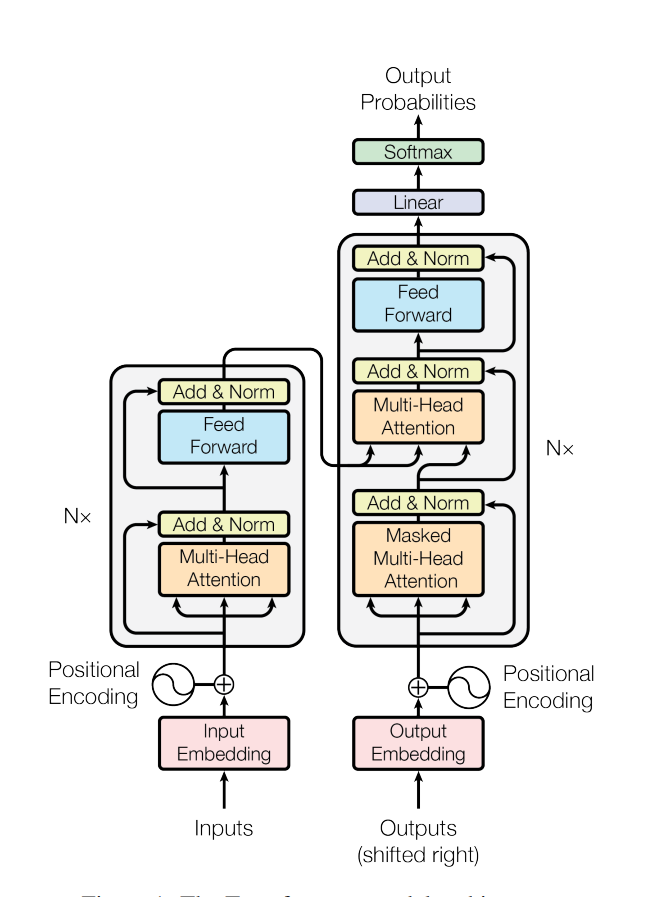

#### 4.1 encoder层

In [160]:
class EncoderLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 多头注意力层
        self.mh = MultiHead()
        # 全连接层
        self.fc = FullyConnectedOutput()
        
    def forward(self, x, mask):
        # 计算自注意力,维度不变
        # [b, 40, 32] -> [b, 40, 32]
        score = self.mh(x, x, x, mask)

        # 全连接输出,维度不变
        # [b, 40, 32] -> [b, 40, 32]
        out = self.fc(score)

        return out

然后将encoderlayer*3

In [161]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = EncoderLayer()
        self.layer_2 = EncoderLayer()
        self.layer_3 = EncoderLayer()

    def forward(self, x, mask):
        x = self.layer_1(x, mask)
        x = self.layer_2(x, mask)
        x = self.layer_3(x, mask)
        return x

#### 4.2 解码器层

In [162]:
class DecoderLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # mask的那部分
        self.mh1 = MultiHead()
        # 从encoder那边来的部分
        self.mh2 = MultiHead()
        # 全连接层
        self.fc = FullyConnectedOutput()
        
    def forward(self, x, y, mask_pad_x, mask_tril_y):
        # 先计算y的自注意力,维度不变
        # [b, 40, 32] -> [b, 40, 32]
        # mask_tril_y为了预测下一个词
        y = self.mh1(y, y, y, mask_tril_y)

        # 结合x和y的注意力计算,维度不变
        # [b, 40, 32],[b, 40, 32] -> [b, 40, 32]
        y = self.mh2(y, x, x, mask_pad_x)

        # 全连接输出,维度不变
        # [b, 40, 32] -> [b, 40, 32]
        y = self.fc(y)

        return y

In [163]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = DecoderLayer()
        self.layer_2 = DecoderLayer()
        self.layer_3 = DecoderLayer()

    def forward(self, x, y, mask_pad_x, mask_tril_y):
        y = self.layer_1(x, y, mask_pad_x, mask_tril_y)
        y = self.layer_2(x, y, mask_pad_x, mask_tril_y)
        y = self.layer_3(x, y, mask_pad_x, mask_tril_y)
        return y

#### 4.3 主模型

In [164]:
class Transformer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embed_x = PositionEmbedding()
        self.embed_y = PositionEmbedding()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.fc_out = torch.nn.Linear(32, 39)
        
    def forward(self, x, y):
        # [b, 1, 40, 40]
        mask_pad_x = mask_pad(x)
        mask_tril_y = mask_tril(y)

        # 编码,添加位置信息
        # x = [b, 40] -> [b, 40, 32]
        # y = [b, 40] -> [b, 40, 32]
        x, y = self.embed_x(x), self.embed_y(y)

        # 编码层计算
        # [b, 40, 32] -> [b, 40, 32]
        x = self.encoder(x, mask_pad_x)

        # 解码层计算
        # [b, 40, 32],[b, 40, 32] -> [b, 40, 32]
        y = self.decoder(x, y, mask_pad_x, mask_tril_y)

        # 全连接输出,维度不变
        # [b, 40, 32] -> [b, 40, 39]
        y = self.fc_out(y)

        return y

### 5、训练与保存模型

In [165]:
import math
import torch

In [166]:
# 模型训练
model = Transformer()

In [167]:
# 计算loss
loss_func = torch.nn.CrossEntropyLoss()

In [168]:
# 优化器选择adam
optim = torch.optim.Adam(model.parameters(), lr=2e-3)
# 学习率是0.002

In [169]:
# 学习率调度器，每3个步长epochs后，学习率*0.5
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.5)

In [173]:
from tqdm import tqdm
# 打开文件以写入结果
# 创建进度条
progress_bar = tqdm(total=len(loader), desc="Training Progress")
with open('transformer_lxy.txt', 'a') as f:
    for epoch in range(1):
        for i, (x, y) in enumerate(loader):
            # x = [8, 40]
            # y = [8, 41]

            # 在训练时,是拿y的每一个字符输入,预测下一个字符,所以不需要最后一个字
            # [8, 40]
            # [8, 40] -> [8, 40, 39]
            pred = model(x, y[:, :-1])

            # [8, 40, 39] -> [320, 39]
            pred = pred.reshape(-1, 39)

            # [8, 41] -> [320]
            # 去掉'<BEGIN>'
            y = y[:, 1:].reshape(-1)

            # 忽略pad
            select = y != dataset_y['<PAD>']
            pred = pred[select]
            y = y[select]

            loss = loss_func(pred, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # 更新进度条
            progress_bar.update(1)
                
            if i % 200 == 0:
                # [select, 39] -> [select]
                pred = pred.argmax(1)
                # 表示沿着第二个维度（即每一行）找到最大值的索引，也就是找到每个样本预测概率最高的类别对应的索引。
                correct = (pred == y).sum().item()
                accuracy = correct / len(pred)
                lr = optim.param_groups[0]['lr']
                
                
                # 将结果写入文件
                f.write("Epoch: {} Step: {} LR: {:.6f} Accuracy: {:.4f} Loss: {}\n".format(epoch, i, lr, accuracy, loss.item()))
        sched.step()
                
# 关闭进度条
progress_bar.close()

Training Progress: 100%|█████████████████████████████████████████████████████████| 12500/12500 [21:01<00:00,  9.91it/s]


### 6、推理模型

输入：a123bc

输出：A987BC

In [175]:
def predict(x):
    # x = [1, 40]:一句话，40个词
    model.eval()
    
    # [1, 1, 40, 40]
    mask_pad_x = mask_pad(x)
    # 初始化输出,这个是固定值
    # [1, 40]
    # [[0,2,2,2...]]
    target = [dataset_y['<BEGIN>']] + [dataset_y['<PAD>']] * 39
    target = torch.LongTensor(target).unsqueeze(0)
    
    # x编码,添加位置信息
    # [1, 40] -> [1, 40, 32]
    x = model.embed_x(x)
    
    # 编码层计算,维度不变
    # [1, 40, 32] -> [1, 40, 32]
    x = model.encoder(x, mask_pad_x)
    
    # 遍历生成第1个词到第39个词
    # 因为是预测，所以最后一个词是预测出来的
    for i in range(39):
        # [1, 40]
        # [[0,2,2,2...]]
        y = target

        # [1, 1, 40, 40]
        mask_tril_y = mask_tril(y)

        # y编码,添加位置信息
        # [1, 40] -> [1, 40, 32]
        y = model.embed_y(y)
        
        # 解码层计算,维度不变
        # [1, 40, 32],[1, 40, 32] -> [1, 40, 32]
        y = model.decoder(x, y, mask_pad_x, mask_tril_y)
        
        # 全连接输出,39分类
        # [1, 40, 32] -> [1, 40, 39]
        out = model.fc_out(y)
        
        # 取出当前词的输出
        # [1, 40, 39] -> [1, 40]
        out = out[:, i, :]
        
        # 取出分类结果
        # [1, 39] -> [1]
        out = out.argmax(dim=1).detach()

        # 以当前词预测下一个词,填到结果中
        target[:, i + 1] = out
        
    return target

In [195]:
# 测试
for i, (x, y) in enumerate(loader):
    break

In [196]:
for i in range(5):
    print(i)
    print('x输入：',''.join([dataset_xr[i] for i in x[i].tolist()]).replace("<BEGIN>", "").split("<END>")[0])
    print('y答案：',''.join([dataset_yr[i] for i in y[i].tolist()]).replace("<BEGIN>", "").split("<END>")[0])
    print('y预测：',''.join([dataset_yr[i] for i in predict(x[i].unsqueeze(0))[0].tolist()]).replace("<BEGIN>", "").split("<END>")[0])


0
x输入： 3788569996da68e241887g65
y答案： 57322541114DA42E869223G45
y预测： 57322541114DA42E869223G45
1
x输入： 8g776715g1846bbe25388648
y答案： 22G334395G9264BBE85722462
y预测： 22G334395G9264BBE85722462
2
x输入： 561e94a53a9d65726e56
y答案： 4549E16A57A1D45384E54
y预测： 4549E16A57A1D45384E54
3
x输入： 618854449g7g5f63e4g9
y答案： 1492256661G3G5F47E6G1
y预测： 1492256661G3G5F47E6G1
4
x输入： 2f1467265e6f52553944376
y答案： 48F9643845E4F58557166734
y预测： 48F9643845E4F58557166734
